## FPN Architecture 

![](images/fpn/fpn-arc.png)

In [1]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['/Users/ZRC/miniconda3/envs/tryit/lib/python36.zip',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/lib-dynload',
 '',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages/IPython/extensions',
 '/Users/ZRC/.ipython',
 '/Users/ZRC']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import Subset


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [4]:
from coke.visualization.image import show_batch

## Model Setting

In [5]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = True

# other
# torch.cuda.empty_cache()
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [6]:
data_transforms = {"train": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()]),
                    "test": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()])
                   }

In [7]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)



train_and_valida_dataset = datasets.MNIST(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.MNIST(root = "data",
                                train = False,
                                transform = data_transforms["test"],
                                download=False)

train_dataset = Subset(train_and_valida_dataset, train_indices)
valid_dataset = Subset(train_and_valida_dataset, valid_indices)




train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

valid_dataloader = DataLoader(dataset = valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, 
               "val": valid_dataloader,
               "test": test_dataloader}

torch.Size([64, 1, 32, 32]) torch.Size([64])


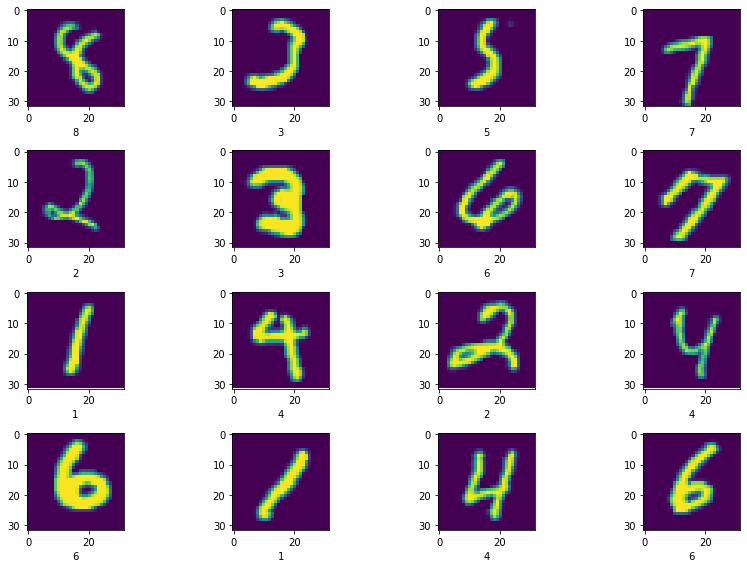

In [8]:
batch_samples,labels = next(iter(train_dataloader))
print(batch_samples.size(),labels.size())
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


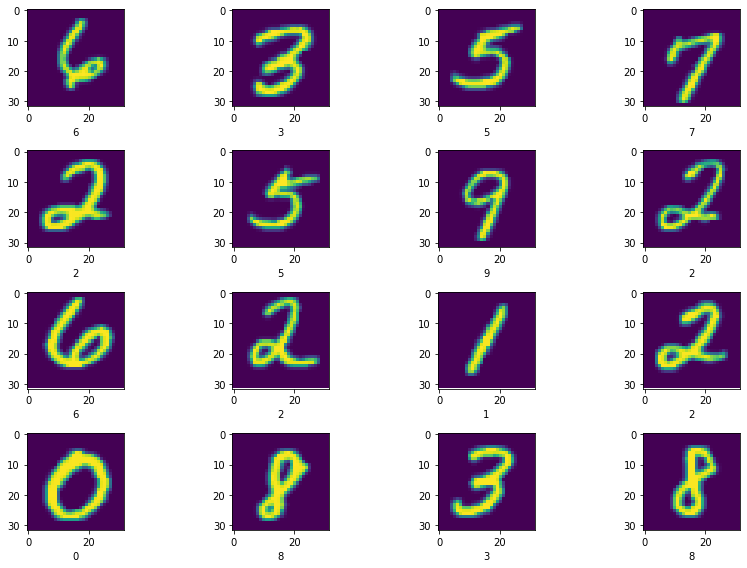

In [9]:
batch_samples,labels = next(iter(valid_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


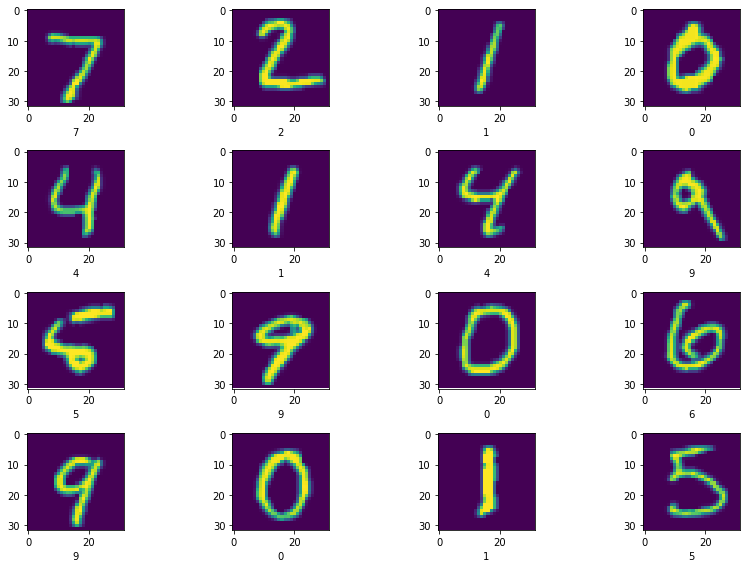

In [10]:
batch_samples,labels = next(iter(test_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

## Model

In [9]:
def conv3x3(inplanes, outplanes, stride = 1):
    return torch.nn.Conv2d(inplanes, 
                           outplanes, 
                           stride=stride,
                           kernel_size=3, 
                           padding = 1,
                           bias=False)

In [31]:
class Bottleneck(torch.nn.Module):
    expansion = 4
    def __init__(self, inplanes, outplanes, stride=1):
        super(Bottleneck, self).__init__()        
        self.seq = torch.nn.Sequential(
            # [1x1]
            torch.nn.Conv2d(inplanes, 
                            outplanes, 
                            kernel_size=1, 
                            bias=False),
            torch.nn.BatchNorm2d(outplanes),
            torch.nn.ReLU(inplace = True),
            
            # [3x3]
            torch.nn.Conv2d(outplanes, 
                            outplanes, 
                            kernel_size=3, 
                            stride=stride,
                            padding=1, 
                            bias=False),
            torch.nn.BatchNorm2d(outplanes),
            torch.nn.ReLU(inplace = True),
            
            # [1x1]
            torch.nn.Conv2d(outplanes, 
                                   outplanes * self.expansion, 
                                   kernel_size=1, 
                                   bias=False),
            torch.nn.BatchNorm2d(outplanes * self.expansion))
        
        
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or inplanes != self.expansion * outplanes: 
            self.shortcut.add_module("shortcut_conv", torch.nn.Conv2d(inplanes,outplanes * self.expansion, 
                                                                      kernel_size=1, 
                                                                      stride = stride,
                                                                      bias = False))
            self.shortcut.add_module("shortcut_bn", torch.nn.BatchNorm2d(outplanes * self.expansion))
            
        
    def forward(self, x):
        out = self.seq(x)
        residule = self.shortcut(x)
        out += self.shortcut(x)
        return F.relu(out)

In [32]:
def test_Bottleneck():
    model = Bottleneck(256,64).to(DEVICE)
    summary(model, (256,28,28))
test_Bottleneck()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          16,384
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,864
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]          16,384
       BatchNorm2d-8          [-1, 256, 28, 28]             512
Total params: 70,400
Trainable params: 70,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 5.36
Params size (MB): 0.27
Estimated Total Size (MB): 6.39
----------------------------------------------------------------


In [39]:
class FPNZrc(torch.nn.Module):

    def __init__(self, block, layers = [2,2,2,2], grasacale = False, num_classes=1000):
        super(FPNZrc, self).__init__()
        
        self.inplanes = 64
        
        if grasacale:
            init_channels = 1
        else:
            init_channels = 3
        
        
        self.pre = torch.nn.Sequential(
            OrderedDict([
                ("conv0", torch.nn.Conv2d(init_channels, 
                                          self.inplanes, 
                                          kernel_size=7, 
                                          stride=2, 
                                          padding=3,
                                          bias=False)),
                ("bn0", torch.nn.BatchNorm2d(self.inplanes)),
                ("relu0", torch.nn.ReLU(inplace=True)),
                ("pool0", torch.nn.MaxPool2d(kernel_size = 3, stride=2, padding=1))
            ]))
        
    
        # Bottom-up layers
        
        self.bp_layer1 = self._make_layers(block, 64,  layers[0])
        self.bp_layer2 = self._make_layers(block, 128, layers[1], stride=2)
        self.bp_layer3 = self._make_layers(block, 256, layers[2], stride=2)
        self.bp_layer4 = self._make_layers(block, 512, layers[3], stride=2)
        
        
         # Top layer
        self.top = torch.nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        
        
        
         # Lateral layers
        self.latlayer1 = torch.nn.Conv2d( 1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = torch.nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = torch.nn.Conv2d( 256, 256, kernel_size=1, stride=1, padding=0)
        
        # Smooth layers
        self.smooth1 = torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        
        
        for name, layer in self.named_modules():
            if isinstance(layer, torch.nn.Conv2d):
                n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
                layer.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(layer, torch.nn.BatchNorm2d):
                layer.weight.data.fill_(1)
                layer.bias.data.zero_()
            
    
    def _make_layers(self, block, planes, multiplier, stride = 1):
        
        strides = [stride] + [1]*(multiplier-1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplanes, planes, stride))
            self.inplanes = planes * block.expansion
        
        return torch.nn.Sequential(*layers)    
    
    
    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y
    
    def forward(self, x):
        c1 = self.pre(x)            # 64
        c2 = self.bp_layer1(c1)     # 64 * 4 = 256
        c3 = self.bp_layer2(c2)     # 128 * 4 = 512
        c4 = self.bp_layer3(c3)     # 256 * 4 = 1024
        c5 = self.bp_layer4(c4)     # 512 * 4 = 2048
        
        p5 = self.top(c5)  # 256 
        p4 = self._upsample_add(p5, self.latlayer1(c4))  # 256 + 256
        p3 = self._upsample_add(p4, self.latlayer2(c3))  # 
        p2 = self._upsample_add(p3, self.latlayer3(c2))
        
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        return p2, p3, p4, p5
    

In [40]:
def test_FPNZrc():
    model = FPNZrc(Bottleneck, [2,2,2,2], num_classes = NUM_CLASSES).to(DEVICE)
    summary(model, (3,28,28))
test_FPNZrc()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [42]:
model = FPNZrc(Bottleneck, [2,2,2,2], num_classes = NUM_CLASSES).to(DEVICE)
model.to(DEVICE)

#### DATA PARALLEL START ####
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)
#### DATA PARALLEL END ####

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [20]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device, metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, train_acc))
            
            print('Epoch: {0:03d}/{1:03d} validation accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, valid_acc))
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return loss_list, train_acc_list, valid_acc_list

In [21]:
loss_list, train_acc_list, valid_acc_list = train_model(
                    model, 
                    data_loader, 
                    optimizer, 
                    NUM_EPOCHS, 
                    device = DEVICE, 
                    batch_size = BATCH_SIZE,
                    metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/921 | Loss: 7.48
Epoch: 001/010 | Batch 050/921 | Loss: 0.37
Epoch: 001/010 | Batch 100/921 | Loss: 0.09
Epoch: 001/010 | Batch 150/921 | Loss: 0.18
Epoch: 001/010 | Batch 200/921 | Loss: 0.15
Epoch: 001/010 | Batch 250/921 | Loss: 0.05
Epoch: 001/010 | Batch 300/921 | Loss: 0.16
Epoch: 001/010 | Batch 350/921 | Loss: 0.03
Epoch: 001/010 | Batch 400/921 | Loss: 0.08
Epoch: 001/010 | Batch 450/921 | Loss: 0.04
Epoch: 001/010 | Batch 500/921 | Loss: 0.14
Epoch: 001/010 | Batch 550/921 | Loss: 0.05
Epoch: 001/010 | Batch 600/921 | Loss: 0.06
Epoch: 001/010 | Batch 650/921 | Loss: 0.10
Epoch: 001/010 | Batch 700/921 | Loss: 0.14
Epoch: 001/010 | Batch 750/921 | Loss: 0.14
Epoch: 001/010 | Batch 800/921 | Loss: 0.08
Epoch: 001/010 | Batch 850/921 | Loss: 0.11
Epoch: 001/010 | Batch 900/921 | Loss: 0.03
Epoch: 001/010 training accuracy: 98.72
Epoch: 001/010 validation accuracy: 98.80
Epoch: 002/010 | Batch 000/921 | Loss: 0.10
Epoch: 002/010 | Batch 050/921 | Loss:

Epoch: 010/010 | Batch 000/921 | Loss: 0.01
Epoch: 010/010 | Batch 050/921 | Loss: 0.01
Epoch: 010/010 | Batch 100/921 | Loss: 0.00
Epoch: 010/010 | Batch 150/921 | Loss: 0.05
Epoch: 010/010 | Batch 200/921 | Loss: 0.00
Epoch: 010/010 | Batch 250/921 | Loss: 0.00
Epoch: 010/010 | Batch 300/921 | Loss: 0.00
Epoch: 010/010 | Batch 350/921 | Loss: 0.00
Epoch: 010/010 | Batch 400/921 | Loss: 0.00
Epoch: 010/010 | Batch 450/921 | Loss: 0.01
Epoch: 010/010 | Batch 500/921 | Loss: 0.04
Epoch: 010/010 | Batch 550/921 | Loss: 0.01
Epoch: 010/010 | Batch 600/921 | Loss: 0.02
Epoch: 010/010 | Batch 650/921 | Loss: 0.00
Epoch: 010/010 | Batch 700/921 | Loss: 0.00
Epoch: 010/010 | Batch 750/921 | Loss: 0.00
Epoch: 010/010 | Batch 800/921 | Loss: 0.01
Epoch: 010/010 | Batch 850/921 | Loss: 0.01
Epoch: 010/010 | Batch 900/921 | Loss: 0.02
Epoch: 010/010 training accuracy: 99.67
Epoch: 010/010 validation accuracy: 99.10


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

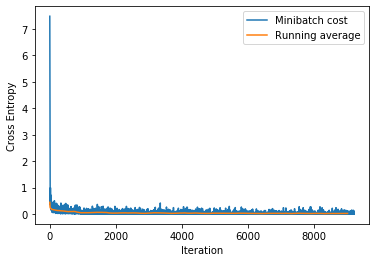

In [23]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

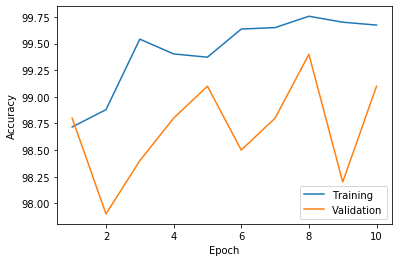

In [24]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                           data_loader=data_loader["test"],
                           device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                            data_loader=data_loader["val"],
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 99.10%
Test ACC: 98.94%
